### Sentiment Analysis is a an NLP task that deals with analyzing a piece of text (eg: sentence, comment, document)  and returning a prediction wheteher the text conveys a positive or a negative sentiment.

# Problem Description:
Data Set: Large Movie Review Dataset commonly known as the IMDB dataset with equal number of observstions in the training and testing set (25k reviews in each set). Also, both data sets contain equal number of positive and negative reviews. The data was collected by Stanford researchers and was used in the paper 'Learning Word Vectors for Sentiment Analysis'

The problem is to determine whether a given movie review is a positive or a negative sentiment.

In [1]:
# Load the important libraries

# To suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Libraries for data manipulation
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

# Libraries for visualization
import matplotlib.pyplot as plt

# Libraries for vectorizing input data
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Libraries for building a model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

# Libraries for assessing the quality of model prediction
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
# set the root directory
root_dir = 'E:/Sentiment_Analysis/data/'

##### Let's now read the train and test data.

In [3]:
df_train = pd.read_csv(root_dir + 'train.csv')
df_test = pd.read_csv(root_dir + 'test.csv')
combine = [df_train, df_test]

In [4]:
df_train.head(3)

,id,review,sentiment
0,0_9.txt,Bromwell High is a cartoon comedy. It ran at t...,1
1,10000_8.txt,Homelessness (or Houselessness as George Carli...,1
2,10001_10.txt,Brilliant over-acting by Lesley Ann Warren. Be...,1


In [5]:
df_train.shape

(25000, 3)

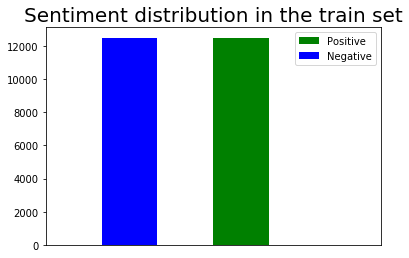

1    12500
0    12500
Name: sentiment, dtype: int64


<Figure size 432x288 with 0 Axes>

In [6]:
plt.hist(df_train[df_train.sentiment == 1].sentiment,
         bins=2, color='green', label='Positive')
plt.hist(df_train[df_train.sentiment == 0].sentiment,
         bins=2, color='blue', label='Negative')
plt.title('Sentiment distribution in the train set', fontsize=20)
plt.xticks([])
plt.xlim(-0.5, 2.5)
plt.legend()
plt.show()
plt.clf()
print(df_train.sentiment.value_counts())

In [7]:
df_train.describe(include=['O'])

,id,review
count,25000,25000
unique,25000,24904
top,12216_4.txt,How has this piece of crap stayed on TV this l...
freq,1,3


##### we do not need the id column in the training dataset so we can drop that and take only the uniqu observations

In [8]:
print("Before", df_train.shape, df_test.shape, combine[0].shape, combine[1].shape)

df_train = df_train.drop('id', axis=1)
combine = [df_train, df_test]

print("After", df_train.shape, df_test.shape, combine[0].shape, combine[1].shape)

Before (25000, 3) (25000, 3) (25000, 3) (25000, 3)
After (25000, 2) (25000, 3) (25000, 2) (25000, 3)


In [9]:
df_train = df_train.drop_duplicates()
print(df_train.shape)
combine = [df_train, df_test]

(24904, 2)


##### Cleaning and pre-processing the data

In [10]:
df_train.review[0]

'Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High\'s satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers\' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I\'m here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn\'t!'

To clean up the raw text, I'll use regular expressions (regex or regexp). It's a sequence of characters that forms a search pattern. The package re can be used to work with regular expressions.

In [11]:
REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

def preprocessReviews(data):
    data.review = [REPLACE_NO_SPACE.sub("", text.lower()) for text in data.review]
    data.review = [REPLACE_WITH_SPACE.sub(" ", text) for text in data.review]
    
    return data

df_train_clean = preprocessReviews(df_train)
df_test_clean = preprocessReviews(df_test)

combine = [df_train_clean, df_test_clean]

In [12]:
print(df_train_clean.review[0])

bromwell high is a cartoon comedy it ran at the same time as some other programs about school life such as teachers my 35 years in the teaching profession lead me to believe that bromwell highs satire is much closer to reality than is teachers the scramble to survive financially the insightful students who can see right through their pathetic teachers pomp the pettiness of the whole situation all remind me of the schools i knew and their students when i saw the episode in which a student repeatedly tried to burn down the school i immediately recalled  at  high a classic line inspector im here to sack one of your teachers student welcome to bromwell high i expect that many adults of my age think that bromwell high is far fetched what a pity that it isnt


In [13]:
print(df_test_clean.review[0])

i went and saw this movie last night after being coaxed to by a few friends of mine ill admit that i was reluctant to see it because from what i knew of ashton kutcher he was only able to do comedy i was wrong kutcher played the character of jake fischer very well and kevin costner played ben randall with such professionalism the sign of a good movie is that it can toy with our emotions this one did exactly that the entire theater which was sold out was overcome by laughter during the first half of the movie and were moved to tears during the second half while exiting the theater i not only saw many women in tears but many full grown men as well trying desperately not to let anyone see them crying this movie was great and i suggest that you go see it before you judge


##### In order to build the model, we need to convert each review to a numerical representation which is callled vectorization.
This can be done by creating one large matrix with one column for every unique word in the corpus (where the corpus is all 50k reviews here). Then we transform each review into one row containing 0s and 1s, where 1 means that the word in the corpus corresponding to that column appears in that review. This process is also known as one hot encoding.

In [14]:
cv = CountVectorizer(binary=True)
cv.fit(df_train_clean.review)
X = cv.transform(df_train_clean.review)
X_test = cv.transform(df_test_clean.review)

### Baseline Model
I'll start with Logistic Regression as it serves as a good baseline model as -
1) It's easy to interpret
2) Linear models tend to perform better on sparsed data sets
3) They learn very fast compared to otehr algorithms

For the simplicity of the model, I'm only going to tune the hyperparameter c which adjusts the regularization.

In [15]:
#label = [1 if i < 12500 else 0 for i in range(25000)]

X_train, X_val, y_train, y_val = train_test_split(
    X, df_train.sentiment, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:    ##How do we choose these values
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))       ## what's % for? What's %s?

Accuracy for C=0.01: 0.8718278188242853
Accuracy for C=0.05: 0.8809829746225506
Accuracy for C=0.25: 0.8788949566334725
Accuracy for C=0.5: 0.876164471570832
Accuracy for C=1: 0.8737552200449727


c = 0.05 gives the best accuracy

##### Training the model
Now, with the optimal value of c, we can train our model on the entire training set and evaluate the accuracy on the test set

In [16]:
final_model = LogisticRegression(C=0.05)
final_model.fit(X, df_train.sentiment)
print ("Final Accuracy: %s" 
       % accuracy_score(df_test.sentiment, final_model.predict(X_test)))        ## Explain the syntax

Final Accuracy: 0.88196


Let's look at the 5 most positive and negative words

In [17]:
feature_to_coef = {
    word: coef for word, coef in zip(
        cv.get_feature_names(), final_model.coef_[0]
    )
}
for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:5]:
    print (best_positive)

('excellent', 0.927752572440215)
('perfect', 0.7961497564740038)
('great', 0.6739653530317321)
('amazing', 0.6109258198225315)
('superb', 0.6072850429678195)


In [18]:
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:5]:
    print (best_negative)

('worst', -1.3590213521105312)
('waste', -1.166796891505745)
('awful', -1.0208874507011403)
('poorly', -0.8749792787852262)
('boring', -0.8578772745807502)


### Further Cleaning the Data - Removing Stopwords

In [19]:
english_stop_words = stopwords.words('english')

def removeStopWords(review_list):
    without_stop_words = []
    for review in review_list:
        without_stop_words.append(
            ' '.join([word for word in review.split() 
                      if word not in english_stop_words])
        )
    return without_stop_words

no_stop_words_train = removeStopWords(df_train_clean.review)
no_stop_words_test = removeStopWords(df_test_clean.review)
no_stop_words_train[0]

'bromwell high cartoon comedy ran time programs school life teachers 35 years teaching profession lead believe bromwell highs satire much closer reality teachers scramble survive financially insightful students see right pathetic teachers pomp pettiness whole situation remind schools knew students saw episode student repeatedly tried burn school immediately recalled high classic line inspector im sack one teachers student welcome bromwell high expect many adults age think bromwell high far fetched pity isnt'

In [20]:
cv = CountVectorizer(binary=True)
cv.fit(no_stop_words_train)
X = cv.transform(no_stop_words_train)
X_test = cv.transform(no_stop_words_test)

X_train, X_val, y_train, y_val = train_test_split(
    X, df_train.sentiment, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))

Accuracy for C=0.01: 0.8798586572438163
Accuracy for C=0.05: 0.8882107292001284
Accuracy for C=0.25: 0.8835528429168005
Accuracy for C=0.5: 0.8803405075489881
Accuracy for C=1: 0.8764857051076133


In [21]:
cv = CountVectorizer(binary=True, stop_words = 'english')
cv.fit(no_stop_words_train)
X = cv.transform(no_stop_words_train)
X_test = cv.transform(no_stop_words_test)

X_train, X_val, y_train, y_val = train_test_split(
    X, df_train.sentiment, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))

Accuracy for C=0.01: 0.864760681015098
Accuracy for C=0.05: 0.875361387728879
Accuracy for C=0.25: 0.8732733697398009
Accuracy for C=0.5: 0.8721490523610665
Accuracy for C=1: 0.8699004176035978


## Text Normalization - Stemming and Lemmatization
Text Normaliztion is the process of converting different words of same meaning into a single word. For example: sleep, sleeping, slept, asleep have the same root 'sleep'. Machine would treat these words differently. So in order to have the machine treat them the same we do text normalization. It can achieved using two processes viz. Stemming and Lemmatization

In [22]:
def getStemmedText(review_list):
    stemmer = PorterStemmer()
    return [' '.join([stemmer.stem(word) for word in review.split()]) for review in review_list]

stemmed_reviews_train = getStemmedText(df_train_clean.review)
stemmed_reviews_test = getStemmedText(df_test_clean.review)

cv = CountVectorizer(binary=True)
cv.fit(stemmed_reviews_train)
X = cv.transform(stemmed_reviews_train)
X_test = cv.transform(stemmed_reviews_test)

X_train, X_val, y_train, y_val = train_test_split(
    X, df_train.sentiment, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))
    
final_stemmed = LogisticRegression(C=0.05)
final_stemmed.fit(X, df_train.sentiment)
print ("Final Accuracy: %s" 
       % accuracy_score(df_test.sentiment, final_stemmed.predict(X_test)))

Accuracy for C=0.01: 0.8766463218760039
Accuracy for C=0.05: 0.8854802441374879
Accuracy for C=0.25: 0.8817860584645036
Accuracy for C=0.5: 0.879537423707035
Accuracy for C=1: 0.8772887889495663
Final Accuracy: 0.87764


In [23]:
def getLemmatizedText(review_list):
    
    lemmatizer = WordNetLemmatizer()
    return [' '.join([lemmatizer.lemmatize(word) for word in review.split()]) for review in review_list]

lemmatized_reviews_train = getLemmatizedText(df_train_clean.review)
lemmatized_reviews_test = getLemmatizedText(df_test_clean.review)

cv = CountVectorizer(binary=True)
cv.fit(lemmatized_reviews_train)
X = cv.transform(lemmatized_reviews_train)
X_test = cv.transform(lemmatized_reviews_test)

X_train, X_val, y_train, y_val = train_test_split(
    X, df_train.sentiment, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))
    
final_lemmatized = LogisticRegression(C=0.25)
final_lemmatized.fit(X, df_train.sentiment)
print ("Final Accuracy: %s" 
       % accuracy_score(df_test.sentiment, final_lemmatized.predict(X_test)))

Accuracy for C=0.01: 0.876164471570832
Accuracy for C=0.05: 0.8817860584645036
Accuracy for C=0.25: 0.8780918727915195
Accuracy for C=0.5: 0.8755220044972695
Accuracy for C=1: 0.8735946032765821
Final Accuracy: 0.8744


## N-gram

In [24]:
ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 2))
ngram_vectorizer.fit(df_train_clean.review)
X = ngram_vectorizer.transform(df_train_clean.review)
X_test = ngram_vectorizer.transform(df_test_clean.review)

X_train, X_val, y_train, y_val = train_test_split(
    X, df_train.sentiment, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))

Accuracy for C=0.01: 0.8813042081593319
Accuracy for C=0.05: 0.8901381304208159
Accuracy for C=0.25: 0.8920655316415034
Accuracy for C=0.5: 0.8917442981047221
Accuracy for C=1: 0.8919049148731127


## Word Count

In [25]:
wc_vectorizer = CountVectorizer(binary=False)
wc_vectorizer.fit(df_train_clean.review)
X = wc_vectorizer.transform(df_train_clean.review)
X_test = wc_vectorizer.transform(df_test_clean.review)

X_train, X_val, y_train, y_val = train_test_split(
    X, df_train.sentiment, train_size = 0.75, 
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))
    
final_wc = LogisticRegression(C=0.05)
final_wc.fit(X, df_train.sentiment)
print ("Final Accuracy: %s" 
       % accuracy_score(df_test.sentiment, final_wc.predict(X_test)))


Accuracy for C=0.01: 0.8774494057179569
Accuracy for C=0.05: 0.8833922261484098
Accuracy for C=0.25: 0.8790555734018631
Accuracy for C=0.5: 0.8779312560231288
Accuracy for C=1: 0.8726309026662383
Final Accuracy: 0.88176


## TF-IDF

In [26]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(df_train_clean.review)
X = tfidf_vectorizer.transform(df_train_clean.review)
X_test = tfidf_vectorizer.transform(df_test_clean.review)

X_train, X_val, y_train, y_val = train_test_split(
    X, df_train.sentiment, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))
    
final_tfidf = LogisticRegression(C=1)
final_tfidf.fit(X, df_train.sentiment)
print ("Final Accuracy: %s" 
       % accuracy_score(df_test.sentiment, final_tfidf.predict(X_test)))

Accuracy for C=0.01: 0.7953742370703502
Accuracy for C=0.05: 0.8273369739800835
Accuracy for C=0.25: 0.8652425313202698
Accuracy for C=0.5: 0.8737552200449727
Accuracy for C=1: 0.88082235785416
Final Accuracy: 0.88232


## SVM

In [27]:
stop_words = ['in', 'of', 'at', 'a', 'the']
ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 3), stop_words=stop_words)
ngram_vectorizer.fit(df_train_clean.review)
X = ngram_vectorizer.transform(df_train_clean.review)
X_test = ngram_vectorizer.transform(df_test_clean.review)

X_train, X_val, y_train, y_val = train_test_split(
    X, df_train.sentiment, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    svm = LinearSVC(C=c)
    svm.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, svm.predict(X_val))))

Accuracy for C=0.01: 0.8851590106007067
Accuracy for C=0.05: 0.8859620944426598
Accuracy for C=0.25: 0.8859620944426598
Accuracy for C=0.5: 0.8858014776742692
Accuracy for C=1: 0.8859620944426598


In [28]:
final_svm = LinearSVC(C=0.01)
final_svm.fit(X, df_train.sentiment)
print ("Final Accuracy: %s" 
       % accuracy_score(df_test.sentiment, final_svm.predict(X_test)))

Final Accuracy: 0.90052
